# Tutorial: Colocalization Analysis - Linking eQTLs to GWAS Signals with `cellink`
This tutorial demonstrates how to perform colocalization analysis to determine whether eQTL signals and GWAS signals share the same causal variant. Colocalization is a powerful approach for interpreting GWAS results by identifying the specific genes and cell types through which genetic variants influence disease risk. When a GWAS identifies a disease-associated locus, the causal mechanism is often unclear. Colocalization analysis tests whether an eQTL signal and a GWAS signal in the same region are driven by the same causal variant (colocalization) or they represent independent association signals that happen to be nearby (linkage).

We'll use the coloc method, a Bayesian approach that calculates posterior probabilities for different colocalization scenarios. You need to install the R package `coloc`. This tutorial assumes you've completed earlier tutorials on eQTL analysis and have familiarity with GWAS summary statistics. The `cellink` package provides convenient wrapper functions fpr TensorQTL, which we use for eQTL mapping here. To use TensorQTL you can install it via `pip install 'cellink[tensorqtl]'`. TensorQTL also requires `plink2`. For visualization of QTL calling results, please consider checking out the [Tutorial: Pseudobulk eQTL Analysis with `cellink`](https://cellink-docs.readthedocs.io/en/latest/tutorials/pseudobulk_eqtl.html). 

## Environment Setup
We begin by importing necessary libraries and defining parameters for colocalization analysis.

In [1]:
import numpy as np
import pandas as pd

from cellink.resources import get_dummy_onek1k, get_gwas_catalog_study_summary_stats
from cellink.tl.external import run_tensorqtl

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

coloc = importr("coloc")
pandas2ri.activate()
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Analysis parameters
chrom = 22
cis_window = 500_000
cell_type = "CD16 Mono"
celltype_key = "predicted.celltype.l2"
original_donor_col = "donor_id"
n_gpcs = 20
pb_gex_key = f"PB_{cell_type}"

# Colocalization parameters
coloc_p1 = 1e-4  # Prior probability a SNP is associated with trait 1
coloc_p2 = 1e-4  # Prior probability a SNP is associated with trait 2
coloc_p12 = 1e-5  # Prior probability a SNP is associated with both traits

/opt/miniconda3/envs/tensorqtl_jaxqtl/lib/python3.10/site-packages/sgkit/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution  # type: ignore[import]


[2025-12-30 00:44:38,429] INFO:rpy2.situation: cffi mode is CFFI_MODE.ANY
[2025-12-30 00:44:38,486] INFO:rpy2.situation: R home found: /opt/miniconda3/envs/tensorqtl_jaxqtl/lib/R


/opt/miniconda3/envs/tensorqtl_jaxqtl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-12-30 00:44:38,782] INFO:rpy2.situation: R library path: 
[2025-12-30 00:44:38,782] INFO:rpy2.situation: LD_LIBRARY_PATH: 
[2025-12-30 00:44:38,787] INFO:rpy2.rinterface_lib.embedded: Default options to initialize R: rpy2, --quiet, --no-save
[2025-12-30 00:44:38,994] INFO:rpy2.rinterface_lib.embedded: R is already initialized. No need to initialize.


## Load and Prepare eQTL Data
First, we'll generate eQTL results using TensorQTL. If you already have eQTL results from previous tutorials, you can skip this section and load your existing data.

In [2]:
dd = get_dummy_onek1k(config_path="../../src/cellink/resources/config/dummy_onek1k.yaml", verify_checksum=False)
print(f"Dataset shape: {dd.shape}")

dd.G.obsm["gPCs"] = dd.G.obsm["gPCs"][dd.G.obsm["gPCs"].columns[:n_gpcs]]

[2025-12-30 00:44:39,981] INFO:root: /Users/larnoldt/cellink_data/dummy_onek1k/dummy_onek1k.dd.h5 already exists
[2025-12-30 00:44:39,982] WARNING:root: No checksum provided, skipping verification
[2025-12-30 00:44:41,205] INFO:root: Loaded dummy OneK1K dataset: (100, 146939, 125366, 34073)
Dataset shape: (100, 146939, 125366, 34073)


In [3]:
dd.aggregate(obs=["donor_id", "sex", "age"], func="first", add_to_obs=True)

In [4]:
# Filter to specific cell type
dd = dd[..., dd.C.obs[celltype_key] == cell_type, :].copy()
print(f"After cell type filtering: {dd.shape}")

# Add donor-level metadata
dd.G.obs["donor_sex"] = dd.G.obs["sex"]
dd.G.obs["donor_age"] = dd.G.obs["age"]

# Generate random labels for demonstration (replace with real phenotypes)
dd.G.obs["donor_labels"] = np.random.randint(2, size=len(dd.G.obs))

# Filter to specific chromosome for faster analysis
dd = dd.sel(G_var=dd.G.var.chrom == str(chrom), C_var=dd.C.var.chrom == str(chrom)).copy()
print(f"After chromosome {chrom} filtering: {dd.shape}")

After cell type filtering: (90, 146939, 1486, 34073)
After chromosome 22 filtering: (90, 136776, 1486, 871)


## Run TensorQTL Nominal Analysis
We'll use TensorQTL's nominal mode to get association statistics for all variant-gene pairs, which we'll need for colocalization.

In [5]:
results_tensorqtl = run_tensorqtl(
    dd,
    prefix="colocalization_eqtl",
    mode="cis_nominal",
    window=cis_window,
    additional_covariates=["gPCs"],
    batch_size=20000,
    run=True,
)

cis_qtl_pairs = results_tensorqtl[0]
print(f"Total variant-gene pairs: {len(cis_qtl_pairs)}")
print(f"Columns: {cis_qtl_pairs.columns.tolist()}")
cis_qtl_pairs.head()

[2025-12-30 00:44:41,510] INFO:cellink._core.donordata: Aggregated X to PB
[2025-12-30 00:44:41,511] INFO:cellink._core.donordata: Observation found for 90 donors.
[2025-12-30 00:44:41,652] INFO:cellink.tl.external._tensorqtl: Performing z-normalization of age.


/Users/larnoldt/sc-genetics/src/cellink/tl/external/_tensorqtl.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  phenotype_write_df = phenotype_write_df.groupby("#chr", sort=False, group_keys=False).apply(
Writing BED: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

Writing FAM... done.
Writing BIM... 

done.
PLINK v2.0.0-a.6.9 64-bit (29 Jan 2025)            cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to colocalization_eqtl.log.
Options in effect:
  --bfile colocalization_eqtl
  --make-pgen
  --out colocalization_eqtl

Start time: Tue Dec 30 00:44:42 2025
24576 MiB RAM detected; reserving 12288 MiB for main workspace.
Using up to 8 compute threads.
90 samples (0 females, 34 males, 56 ambiguous; 90 founders) loaded from
colocalization_eqtl.fam.
136776 variants loaded from colocalization_eqtl.bim.
Note: No phenotype data present.
Writing colocalization_eqtl.psam ... done.
Writing colocalization_eqtl.pvar ... 1010111112121313141415151616171718181919202021212222232324252526262727282829293030313132323333343435353636373738383939404041414242434344444545464647474848495050515152525353545455555656575758585959606061616262636364646565666667676868696970707171727273737475757676777778787979808081818282838384848585868687878888898

/opt/miniconda3/envs/tensorqtl_jaxqtl/lib/python3.10/site-packages/tensorqtl/core.py:423: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pos_df.groupby('chr', sort=False, group_keys=False).apply(lambda x: x.sort_values(['start', 'end']))


  * checking phenotypes: 446/446
  * Computing associations
    Mapping chromosome 22
    processing phenotype 446/446
    time elapsed: 0.03 min
    * writing output
done.
[Dec 30 00:44:49] Finished mapping
Total variant-gene pairs: 1737760
Columns: ['phenotype_id', 'variant_id', 'start_distance', 'end_distance', 'af', 'ma_samples', 'ma_count', 'pval_nominal', 'slope', 'slope_se']


,phenotype_id,variant_id,start_distance,end_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se
0,ENSG00000177663,22_16585130_T_C,-499825,-530563,0.977778,4,4,0.706084,-0.065519,0.172973
1,ENSG00000177663,22_16585144_G_A,-499811,-530549,0.905556,15,17,0.969395,-0.002678,0.069540
2,ENSG00000177663,22_16585510_C_G,-499445,-530183,0.483333,62,87,0.436520,0.031384,0.040086
3,ENSG00000177663,22_16585603_G_A,-499352,-530090,0.744444,39,46,0.906565,0.005665,0.048079
4,ENSG00000177663,22_16585810_T_C,-499145,-529883,0.727778,38,49,0.476285,-0.033120,0.046229


In [6]:
cis_qtl_pairs = cis_qtl_pairs[~cis_qtl_pairs["slope"].isna()]

## Parse and Format eQTL Results
We'll organize the eQTL results by gene for easier colocalization analysis.

In [7]:
def prepare_eqtl_for_coloc(eqtl_results, gene_id):
    """
    Prepare eQTL results for a specific gene for coloc analysis.

    Parameters
    ----------
    eqtl_results : pd.DataFrame
        TensorQTL nominal output
    gene_id : str
        Gene identifier

    Returns
    -------
    pd.DataFrame
        Formatted results with required columns
    """
    gene_data = eqtl_results[eqtl_results["phenotype_id"] == gene_id].copy()

    if len(gene_data) == 0:
        return None

    gene_data = gene_data.rename(
        columns={"variant_id": "SNP", "pval_nominal": "pvalue", "slope": "beta", "slope_se": "se"}
    )

    gene_data["varbeta"] = gene_data["se"] ** 2

    gene_data[["chr", "pos", "ref", "alt"]] = gene_data["SNP"].str.split("_", expand=True)
    gene_data["pos"] = gene_data["pos"].astype(int)

    return gene_data[["SNP", "chr", "pos", "ref", "alt", "beta", "varbeta", "pvalue"]]


example_gene = cis_qtl_pairs["phenotype_id"].iloc[0]
eqtl_formatted = prepare_eqtl_for_coloc(cis_qtl_pairs, example_gene)
print(f"\nFormatted eQTL data for {example_gene}:")
print(f"Variants: {len(eqtl_formatted)}")
eqtl_formatted.head()


Formatted eQTL data for ENSG00000177663:
Variants: 4338


,SNP,chr,pos,ref,alt,beta,varbeta,pvalue
0,22_16585130_T_C,22,16585130,T,C,-0.065519,0.029920,0.706084
1,22_16585144_G_A,22,16585144,G,A,-0.002678,0.004836,0.969395
2,22_16585510_C_G,22,16585510,C,G,0.031384,0.001607,0.436520
3,22_16585603_G_A,22,16585603,G,A,0.005665,0.002312,0.906565
4,22_16585810_T_C,22,16585810,T,C,-0.033120,0.002137,0.476285


## Download and Prepare GWAS Summary Statistics
Now we'll download GWAS summary statistics from the GWAS Catalog. We'll use a study of coronary artery disease as an example.

In [8]:
gwas_path = get_gwas_catalog_study_summary_stats("GCST90043957", return_path=True)  # TODO
print(f"Downloaded GWAS summary statistics to: {gwas_path}")

[2025-12-30 00:44:49,833] INFO:root: Fetching https://www.ebi.ac.uk/gwas/rest/api/v2/studies/GCST90043957
[2025-12-30 00:44:51,205] INFO:root: Found harmonised file: 34737426-GCST90043957-MONDO_0021661.h.tsv.gz
[2025-12-30 00:44:51,206] INFO:root: Downloading http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST90043001-GCST90044000/GCST90043957/harmonised/34737426-GCST90043957-MONDO_0021661.h.tsv.gz to /Users/larnoldt/cellink_data/GCST90043957_summary_stats.tsv.gz
Downloaded GWAS summary statistics to: /Users/larnoldt/cellink_data/GCST90043957_summary_stats.tsv.gz


In [9]:
gwas_data = pd.read_csv(gwas_path, sep="\t", compression="gzip")
print(f"\nGWAS data shape: {gwas_data.shape}")
print(f"Columns: {gwas_data.columns.tolist()}")
gwas_data.head()


GWAS data shape: (11831294, 25)
Columns: ['hm_variant_id', 'hm_rsid', 'hm_chrom', 'hm_pos', 'hm_other_allele', 'hm_effect_allele', 'hm_beta', 'hm_odds_ratio', 'hm_ci_lower', 'hm_ci_upper', 'hm_effect_allele_frequency', 'hm_code', 'chromosome', 'variant_id', 'base_pair_location', 'effect_allele', 'other_allele', 'n', 'effect_allele_frequency', 'beta', 'standard_error', 'p_value', 'odds_ratio', 'ci_lower', 'ci_upper']


,hm_variant_id,hm_rsid,hm_chrom,hm_pos,hm_other_allele,hm_effect_allele,hm_beta,hm_odds_ratio,hm_ci_lower,hm_ci_upper,...,effect_allele,other_allele,n,effect_allele_frequency,beta,standard_error,p_value,odds_ratio,ci_lower,ci_upper
0,1_69569_T_C,rs2531267,1.0,69569.0,T,C,0.084831,NaN,NaN,NaN,...,C,T,456285,0.000151,0.084831,0.481220,0.860071,NaN,NaN,NaN
1,1_758351_A_G,rs12238997,1.0,758351.0,A,G,0.004345,NaN,NaN,NaN,...,G,A,418020,0.093649,0.004345,0.020920,0.835477,NaN,NaN,NaN
2,1_782207_G_A,rs144155419,1.0,782207.0,G,A,-0.012750,NaN,NaN,NaN,...,A,G,446865,0.010507,-0.012750,0.057393,0.824200,NaN,NaN,NaN
3,1_787949_A_T,rs189787166,1.0,787949.0,A,T,0.005307,NaN,NaN,NaN,...,T,A,455943,0.001320,0.005307,0.158911,0.973358,NaN,NaN,NaN
4,1_794707_T_C,rs148120343,1.0,794707.0,T,C,0.023661,NaN,NaN,NaN,...,C,T,432816,0.043963,0.023661,0.029122,0.416506,NaN,NaN,NaN


## Filter GWAS to Chromosome and Region
For colocalization, we only need GWAS variants that overlap with our eQTL analysis region.

In [10]:
def prepare_gwas_for_coloc(gwas_data, chrom, start, end):
    """
    Prepare GWAS data for a specific region for coloc analysis.
    """
    gwas_region = gwas_data[
        (gwas_data["chromosome"] == chrom)
        & (gwas_data["base_pair_location"] >= start)
        & (gwas_data["base_pair_location"] <= end)
    ].copy()

    if len(gwas_region) == 0:
        return None

    gwas_region["SNP"] = (
        gwas_region["chromosome"].astype(str)
        + "_"
        + gwas_region["base_pair_location"].astype(str)
        + "_"
        + gwas_region["other_allele"]
        + "_"
        + gwas_region["effect_allele"]
    )

    gwas_region = gwas_region.rename(
        columns={
            "chromosome": "chr",
            "base_pair_location": "pos",
            "p_value": "pvalue",
            "beta": "beta",
            "standard_error": "se",
            "effect_allele": "alt",
            "other_allele": "ref",
        }
    )

    gwas_region["varbeta"] = gwas_region["se"] ** 2

    return gwas_region[["SNP", "chr", "pos", "ref", "alt", "beta", "varbeta", "pvalue"]]


gene_info = dd.C.var.loc[example_gene]
region_start = max(0, gene_info["start"] - cis_window)
region_end = gene_info["end"] + cis_window

gwas_formatted = prepare_gwas_for_coloc(gwas_data, chrom, region_start, region_end)
print(f"\nGWAS variants in region: {len(gwas_formatted) if gwas_formatted is not None else 0}")
if gwas_formatted is not None:
    gwas_formatted.head()


GWAS variants in region: 4237


## Harmonize eQTL and GWAS Data
Before running colocalization, we need to ensure that both datasets share the same set of variants and have alleles aligned in the same direction.

In [11]:
def harmonize_datasets(eqtl_data, gwas_data):
    """
    Harmonize eQTL and GWAS datasets for colocalization.

    Ensures both datasets contain the same variants with aligned alleles.
    """
    merged = eqtl_data.merge(gwas_data, on="SNP", suffixes=("_eqtl", "_gwas"), how="inner")

    if len(merged) == 0:
        print("Warning: No overlapping variants found!")
        return None, None, 0

    print(f"Overlapping variants: {len(merged)}")

    # Check for allele flips (ref/alt swapped)
    same_alleles = (merged["ref_eqtl"] == merged["ref_gwas"]) & (merged["alt_eqtl"] == merged["alt_gwas"])

    flipped_alleles = (merged["ref_eqtl"] == merged["alt_gwas"]) & (merged["alt_eqtl"] == merged["ref_gwas"])

    valid = same_alleles | flipped_alleles
    merged = merged[valid].copy()
    n_flipped = flipped_alleles[valid].sum()

    print(f"Variants after allele harmonization: {len(merged)}")
    print(f"Alleles flipped: {n_flipped}")

    merged.loc[flipped_alleles[valid], "beta_gwas"] *= -1

    eqtl_harmonized = pd.DataFrame(
        {
            "SNP": merged["SNP"],
            "chr": merged["chr_eqtl"],
            "pos": merged["pos_eqtl"],
            "beta": merged["beta_eqtl"],
            "varbeta": merged["varbeta_eqtl"],
            "pvalue": merged["pvalue_eqtl"],
        }
    )

    gwas_harmonized = pd.DataFrame(
        {
            "SNP": merged["SNP"],
            "chr": merged["chr_gwas"],
            "pos": merged["pos_gwas"],
            "beta": merged["beta_gwas"],
            "varbeta": merged["varbeta_gwas"],
            "pvalue": merged["pvalue_gwas"],
        }
    )

    return eqtl_harmonized, gwas_harmonized, n_flipped


eqtl_harm, gwas_harm, n_flipped = harmonize_datasets(eqtl_formatted, gwas_formatted)

if eqtl_harm is not None:
    print(f"\nReady for colocalization with {len(eqtl_harm)} shared variants")

Overlapping variants: 2338
Variants after allele harmonization: 2338
Alleles flipped: 0

Ready for colocalization with 2338 shared variants


## Run Colocalization Analysis with coloc
Now we'll run the coloc Bayesian colocalization analysis using R's coloc package via rpy2.

In [12]:
def run_coloc(eqtl_data, gwas_data, n_samples_eqtl, n_samples_gwas, p1=1e-4, p2=1e-4, p12=1e-5, sdY=1.0):
    """
    Run coloc colocalization analysis using R's coloc package.

    Parameters
    ----------
    eqtl_data : pd.DataFrame
        eQTL summary statistics (beta, varbeta, pvalue, SNP)
    gwas_data : pd.DataFrame
        GWAS summary statistics (beta, varbeta, pvalue, SNP)
    n_samples_eqtl : int
        Sample size for eQTL study
    n_samples_gwas : int
        Sample size for GWAS study
    p1 : float
        Prior probability a SNP is associated with trait 1
    p2 : float
        Prior probability a SNP is associated with trait 2
    p12 : float
        Prior probability a SNP is associated with both traits
    sdY : float
        Standard deviation of the quantitative trait (eQTL expression)
        Default is 1.0 for standardized/normalized expression

    Returns
    -------
    dict
        Colocalization results including posterior probabilities
    """
    dataset1 = ro.ListVector(
        {
            "beta": ro.FloatVector(eqtl_data["beta"].values),
            "varbeta": ro.FloatVector(eqtl_data["varbeta"].values),
            "snp": ro.StrVector(eqtl_data["SNP"].values),
            "type": "quant",
            "N": n_samples_eqtl,
            "sdY": sdY,
        }
    )

    dataset2 = ro.ListVector(
        {
            "beta": ro.FloatVector(gwas_data["beta"].values),
            "varbeta": ro.FloatVector(gwas_data["varbeta"].values),
            "snp": ro.StrVector(gwas_data["SNP"].values),
            "type": "cc",
            "N": n_samples_gwas,
        }
    )

    result = coloc.coloc_abf(dataset1=dataset1, dataset2=dataset2, p1=p1, p2=p2, p12=p12)

    summary = result.rx2("summary")
    results_dict = {
        "nsnps": int(summary[0]),
        "PP.H0.abf": float(summary[1]),
        "PP.H1.abf": float(summary[2]),
        "PP.H2.abf": float(summary[3]),
        "PP.H3.abf": float(summary[4]),
        "PP.H4.abf": float(summary[5]),
    }

    return results_dict


if eqtl_harm is not None:
    coloc_result = run_coloc(
        eqtl_data=eqtl_harm,
        gwas_data=gwas_harm,
        n_samples_eqtl=dd.shape[0],
        n_samples_gwas=456348,
        p1=coloc_p1,
        p2=coloc_p2,
        p12=coloc_p12,
    )

    print(f"\n{'='*60}")
    print(f"Colocalization Results for {example_gene}")
    print(f"{'='*60}")
    print(f"Number of SNPs: {coloc_result['nsnps']}")
    print("\nPosterior Probabilities:")
    print(f"  PP.H0 (no association): {coloc_result['PP.H0.abf']:.4f}")
    print(f"  PP.H1 (eQTL only): {coloc_result['PP.H1.abf']:.4f}")
    print(f"  PP.H2 (GWAS only): {coloc_result['PP.H2.abf']:.4f}")
    print(f"  PP.H3 (both, different variants): {coloc_result['PP.H3.abf']:.4f}")
    print(f"  PP.H4 (colocalization): {coloc_result['PP.H4.abf']:.4f}")
    print("\nInterpretation: ", end="")
    if coloc_result["PP.H4.abf"] > 0.8:
        print("Strong evidence for colocalization ✓")
    elif coloc_result["PP.H4.abf"] > 0.5:
        print("Moderate evidence for colocalization")
    elif coloc_result["PP.H3.abf"] > 0.5:
        print("Likely independent signals")
    else:
        print("Inconclusive")

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 2.30e-06  8.50e-01  1.42e-07  5.22e-02  9.83e-02 
[1] "PP abf for shared variant: 9.83%"

Colocalization Results for ENSG00000177663
Number of SNPs: 2338

Posterior Probabilities:
  PP.H0 (no association): 0.0000
  PP.H1 (eQTL only): 0.8496
  PP.H2 (GWAS only): 0.0000
  PP.H3 (both, different variants): 0.0522
  PP.H4 (colocalization): 0.0983

Interpretation: Inconclusive


## Genome-wide Colocalization Screen
Now let's perform colocalization analysis for all eGenes (genes with significant eQTLs).

In [13]:
def screen_colocalizations(eqtl_results, gwas_data, gene_list, dd, chrom, cis_window=500_000, pp_h4_threshold=0.5):
    """
    Perform genome-wide colocalization screen.
    """
    results = []

    for gene_id in gene_list:
        try:
            if gene_id not in dd.C.var.index:
                continue
            gene_info = dd.C.var.loc[gene_id]

            eqtl_gene = prepare_eqtl_for_coloc(eqtl_results, gene_id)
            if eqtl_gene is None or len(eqtl_gene) < 10:
                continue

            region_start = max(0, gene_info["start"] - cis_window)
            region_end = gene_info["end"] + cis_window
            gwas_region = prepare_gwas_for_coloc(gwas_data, chrom, region_start, region_end)

            if gwas_region is None or len(gwas_region) < 10:
                continue

            eqtl_harm, gwas_harm, n_flipped = harmonize_datasets(eqtl_gene, gwas_region)

            if eqtl_harm is None or len(eqtl_harm) < 10:
                continue

            coloc_result = run_coloc(
                eqtl_data=eqtl_harm, gwas_data=gwas_harm, n_samples_eqtl=dd.shape[0], n_samples_gwas=456348
            )

            results.append(
                {
                    "gene_id": gene_id,
                    "gene_name": gene_info.get("gene_name", gene_id),
                    "chr": chrom,
                    "start": gene_info["start"],
                    "end": gene_info["end"],
                    "n_snps": coloc_result["nsnps"],
                    "PP.H0": coloc_result["PP.H0.abf"],
                    "PP.H1": coloc_result["PP.H1.abf"],
                    "PP.H2": coloc_result["PP.H2.abf"],
                    "PP.H3": coloc_result["PP.H3.abf"],
                    "PP.H4": coloc_result["PP.H4.abf"],
                }
            )

        except Exception as e:
            print(f"Error processing {gene_id}: {e}")
            continue

    results_df = pd.DataFrame(results)

    if len(results_df) > 0:
        results_df = results_df.sort_values("PP.H4", ascending=False)
        significant = results_df[results_df["PP.H4"] >= pp_h4_threshold]

        print("\nGenome-wide Colocalization Summary:")
        print(f"  Genes tested: {len(results_df)}")
        print(f"  PP.H4 >= {pp_h4_threshold}: {len(significant)}")
        print(f"  PP.H4 >= 0.8 (strong): {(results_df['PP.H4'] >= 0.8).sum()}")

    return results_df


genes_with_eqtls = cis_qtl_pairs.groupby("phenotype_id").size()
genes_to_test = genes_with_eqtls[genes_with_eqtls >= 50].index.tolist()  # [:20]  # Test first 20 for demo #TODO

print(f"Testing {len(genes_to_test)} genes for colocalization...")

coloc_results = screen_colocalizations(
    eqtl_results=cis_qtl_pairs,
    gwas_data=gwas_data,
    gene_list=genes_to_test,
    dd=dd,
    chrom=chrom,
    cis_window=cis_window,
    pp_h4_threshold=0.5,
)

Testing 446 genes for colocalization...
Overlapping variants: 2921
Variants after allele harmonization: 2921
Alleles flipped: 0
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
  0.71300   0.19200   0.07000   0.01880   0.00672 
[1] "PP abf for shared variant: 0.672%"
Overlapping variants: 2428
Variants after allele harmonization: 2428
Alleles flipped: 0
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
  0.73700   0.18000   0.06120   0.01500   0.00614 
[1] "PP abf for shared variant: 0.614%"
Overlapping variants: 2493
Variants after allele harmonization: 2493
Alleles flipped: 0
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 1.32e-04  6.94e-01  1.12e-05  5.88e-02  2.47e-01 
[1] "PP abf for shared variant: 24.7%"
Overlapping variants: 2632
Variants after allele harmonization: 2632
Alleles flipped: 0
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 3.99e-11  8.23e-01  7.60e-12  1.57e-01  1.97e-02 
[1] "PP abf for shared variant: 1.97%"
Overlapping variants: 3914
Variants after 

In [14]:
coloc_results

,gene_id,gene_name,chr,start,end,n_snps,PP.H0,PP.H1,PP.H2,PP.H3,PP.H4
259,ENSG00000186998,ENSG00000186998,22,29205896.0,29259597.0,2125,1.015944e-16,0.311081,5.492107e-17,0.167646,0.521273
2,ENSG00000025770,ENSG00000025770,22,50508224.0,50524780.0,2493,1.316848e-04,0.694187,1.119525e-05,0.058770,0.246901
164,ENSG00000128159,ENSG00000128159,22,50217689.0,50245023.0,3255,2.366452e-05,0.642525,4.756293e-06,0.128912,0.228535
115,ENSG00000100298,ENSG00000100298,22,39097224.0,39104067.0,2080,1.417083e-50,0.759303,9.827111e-52,0.052468,0.188229
229,ENSG00000183773,ENSG00000183773,22,20965108.0,20981360.0,1508,7.370555e-01,0.051550,4.849696e-02,0.003232,0.159665
...,...,...,...,...,...,...,...,...,...,...,...
197,ENSG00000161180,ENSG00000161180,22,21632716.0,21637329.0,1416,NaN,NaN,NaN,NaN,NaN
295,ENSG00000211660,ENSG00000211660,22,22697789.0,22698407.0,1232,NaN,NaN,NaN,NaN,NaN
309,ENSG00000218357,ENSG00000218357,22,47402297.0,47488149.0,3044,NaN,NaN,NaN,NaN,NaN
393,ENSG00000273216,ENSG00000273216,22,29316744.0,29317220.0,1959,NaN,NaN,NaN,NaN,NaN


## Visualize Colocalization Results
Let's create visualizations to interpret the colocalization findings. We now investigate the results for PP.H4, which can be interpreted as the following:
- PP.H4 > 0.8: Strong evidence for colocalization (eQTL and GWAS signals likely share a causal variant) - prioritize for follow-up
- PP.H4 0.5-0.8: Moderate evidence - may warrant additional investigation
- PP.H3 > 0.8: Strong evidence for independent signals - both eQTL and GWAS exist but driven by different variants
- Low all PPs: Insufficient power or weak signals

As we can see, we only identify one gene in our dummy dataset with a moderate colocalization between eQTL and GWAS hits and no colocalization with strong evidence between eQTL and GWAS hits. Please note, that this is due to subsampling of the original dataset.

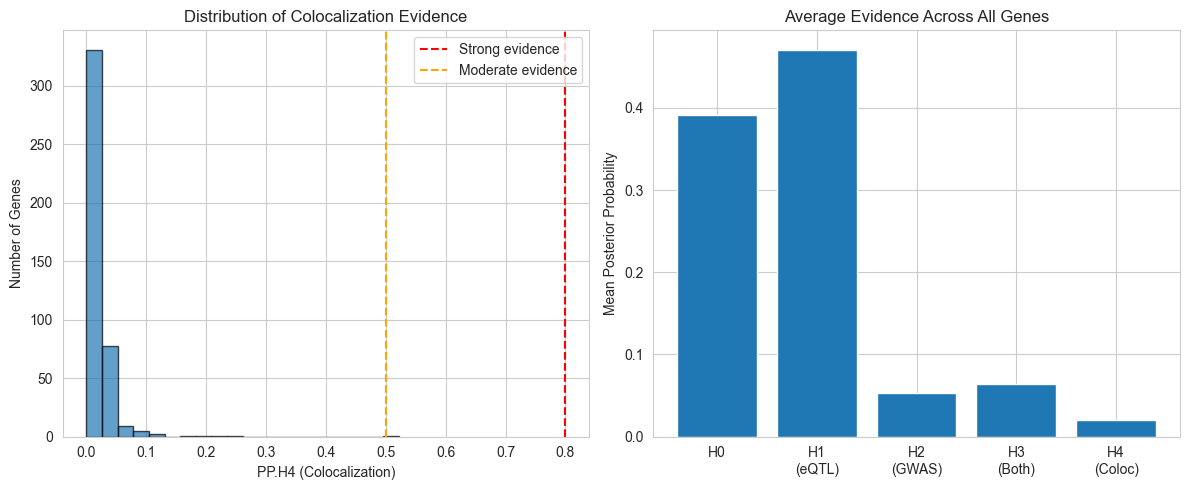

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(coloc_results["PP.H4"], bins=20, edgecolor="black", alpha=0.7)
axes[0].axvline(0.8, color="red", linestyle="--", label="Strong evidence")
axes[0].axvline(0.5, color="orange", linestyle="--", label="Moderate evidence")
axes[0].set_xlabel("PP.H4 (Colocalization)")
axes[0].set_ylabel("Number of Genes")
axes[0].set_title("Distribution of Colocalization Evidence")
axes[0].legend()

pp_cols = ["PP.H0", "PP.H1", "PP.H2", "PP.H3", "PP.H4"]
pp_means = coloc_results[pp_cols].mean()
axes[1].bar(range(len(pp_means)), pp_means.values)
axes[1].set_xticks(range(len(pp_means)))
axes[1].set_xticklabels(["H0", "H1\n(eQTL)", "H2\n(GWAS)", "H3\n(Both)", "H4\n(Coloc)"])
axes[1].set_ylabel("Mean Posterior Probability")
axes[1].set_title("Average Evidence Across All Genes")

plt.tight_layout()
plt.show()

if len(coloc_results[coloc_results["PP.H4"] >= 0.8]) > 0:
    print("\nGenes with Strong Colocalization Evidence (PP.H4 >= 0.8):")
    strong_coloc = coloc_results[coloc_results["PP.H4"] >= 0.8][["gene_id", "gene_name", "n_snps", "PP.H4", "PP.H3"]]
    print(strong_coloc.to_string(index=False))

## Integration with cellink: Storing Results
Now let's add the colocalization results back to our DonorData object for easy integration with downstream analyses.

In [20]:
def add_coloc_results_to_cellink(dd, coloc_results, gwas_trait_name="CAD"):
    """
    Add colocalization results to the DonorData C.var annotations.
    """
    coloc_cols = {
        "PP.H4": f"coloc_{gwas_trait_name}_PP_H4",
        "PP.H3": f"coloc_{gwas_trait_name}_PP_H3",
        "PP.H2": f"coloc_{gwas_trait_name}_PP_H2",
        "PP.H1": f"coloc_{gwas_trait_name}_PP_H1",
        "PP.H0": f"coloc_{gwas_trait_name}_PP_H0",
        "n_snps": f"coloc_{gwas_trait_name}_n_snps",
    }

    for new_col in coloc_cols.values():
        dd.C.var[new_col] = np.nan

    for _, row in coloc_results.iterrows():
        gene_id = row["gene_id"]
        if gene_id in dd.C.var.index:
            for old_col, new_col in coloc_cols.items():
                dd.C.var.loc[gene_id, new_col] = row[old_col]

    classification_col = f"coloc_{gwas_trait_name}_class"
    dd.C.var[classification_col] = "not_tested"

    pp_h4_col = coloc_cols["PP.H4"]
    tested_genes = dd.C.var[pp_h4_col].notna()

    dd.C.var.loc[tested_genes & (dd.C.var[pp_h4_col] >= 0.8), classification_col] = "strong_coloc"
    dd.C.var.loc[tested_genes & (dd.C.var[pp_h4_col] >= 0.5) & (dd.C.var[pp_h4_col] < 0.8), classification_col] = (
        "moderate_coloc"
    )
    dd.C.var.loc[tested_genes & (dd.C.var[pp_h4_col] < 0.5), classification_col] = "no_coloc"

    print("\nAdded colocalization results to dd.C.var:")
    print(f"  Columns added: {list(coloc_cols.values())}")
    print(f"  Classification column: {classification_col}")
    print("\nColocalization Summary:")
    print(dd.C.var[classification_col].value_counts())

    return dd


dd = add_coloc_results_to_cellink(dd, coloc_results, gwas_trait_name="CAD")

print("\nGene annotations with colocalization results:")
coloc_annot_cols = [col for col in dd.C.var.columns if "coloc_" in col]
print(dd.C.var[coloc_annot_cols].loc[coloc_results["gene_id"]].head(10))


Added colocalization results to dd.C.var:
  Columns added: ['coloc_CAD_PP_H4', 'coloc_CAD_PP_H3', 'coloc_CAD_PP_H2', 'coloc_CAD_PP_H1', 'coloc_CAD_PP_H0', 'coloc_CAD_n_snps']
  Classification column: coloc_CAD_class

Colocalization Summary:
coloc_CAD_class
not_tested        441
no_coloc          429
moderate_coloc      1
Name: count, dtype: int64

Gene annotations with colocalization results:
                 coloc_CAD_PP_H4  coloc_CAD_PP_H3  coloc_CAD_PP_H2  \
Geneid                                                               
ENSG00000186998         0.521273         0.167646     5.492107e-17   
ENSG00000025770         0.246901         0.058770     1.119525e-05   
ENSG00000128159         0.228535         0.128912     4.756293e-06   
ENSG00000100298         0.188229         0.052468     9.827111e-52   
ENSG00000183773         0.159665         0.003232     4.849696e-02   
ENSG00000236499         0.128672         0.136431     1.742348e-09   
ENSG00000249222         0.111019         0.